In [1]:
import sys
import rootpath
sys.path.append(rootpath.detect())

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import viridis
import wfg
from scipy.spatial import distance_matrix
from scipy.spatial.distance import cdist 

from testsuite.utilities import Pareto_split

In [2]:
n_samples= 5000
n_pool  = 200

In [3]:
N = n_samples 
M = 3                                   # Number of objectives
kfactor = 2
lfactor = 2

k = kfactor*(M-1)
l = lfactor*2

func = wfg.WFG2

f = np.zeros((N, M))
for n in range(N):
    z = wfg.random_soln(k, l, func.__name__)
    f[n,:] = func(z, k, M)

pi, di = Pareto_split(f, return_indices=True)

In [4]:
print(f.shape)
print(pi.shape)
print(di.shape)

(5000, 3)
(1293,)
(3707,)


In [5]:
dm_initial = distance_matrix(f[pi][:n_pool], f[pi][:n_pool])
np.fill_diagonal(dm_initial, dm_initial.max())

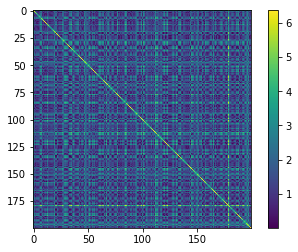

In [6]:
plt.imshow(dm_initial)
plt.colorbar()

In [7]:
density_initial = np.sum(dm_initial<1.7, axis=0)
print(density_initial.min())
w_initial = 1/density_initial

1


In [8]:
col_initial = (w_initial-w_initial.min())/(w_initial.max()-w_initial.min())
col_initial.shape

(200,)

Text(0.5, 1.0, 'density distribution')

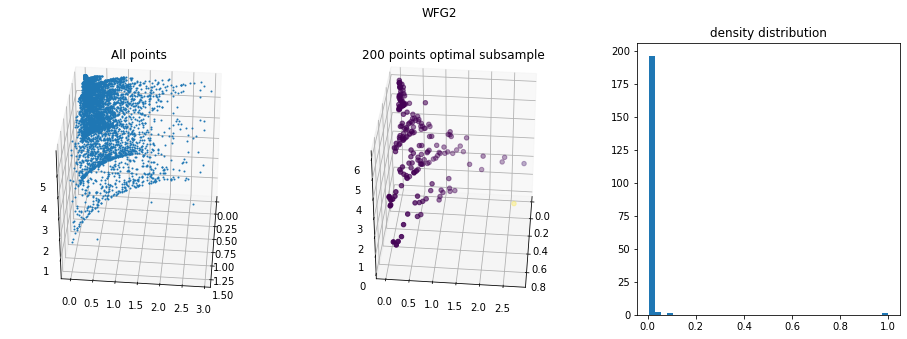

In [9]:
fig = plt.figure(figsize=[16,5])
ax0 = fig.add_subplot(1, 3, 1, projection='3d')
ax1 = fig.add_subplot(1, 3, 2, projection='3d')
ax2 = fig.add_subplot(1, 3, 3)
ax0.plot(*f.T, '.', ms=2, c="C0")
ax1.scatter(*f[pi][:n_pool].T, c=col_initial)
ax0.view_init(elev=35, azim=5)
ax1.view_init(elev=35, azim=5)
ax2.hist(w_initial, bins=40)
plt.suptitle(func.__name__)

ax0.set_title('All points')
ax1.set_title('200 points optimal subsample')
ax2.set_title('density distribution')

In [15]:
def down_sample(y, out_size):
    """
    Down samples point pool y to size out_size, keeping the 
    most sparse population possible.
    
    params:
        y [np.ndarray]: initial poolof points to be downsampled
        dimensions = [n_points, point_dim]
        out_size [int]: number of points in downsampled population
        muse be smaller than y.shape[0].
    """
    assert out_size<y.shape[0]
    pool = y.copy()
    in_pool = pool[:out_size] 
    out_pool = pool[out_size:] 
    M = distance_matrix(in_pool, in_pool)
    np.fill_diagonal(M, np.nan)
    for p in out_pool:
        arg_p = np.nanargmin(M)
        i = arg_p//M.shape[0]
        j = arg_p%M.shape[0]
        min_M = M[i,j]
        
        p_dist = cdist(p[np.newaxis,:], in_pool)[0]
        if p_dist.min()<min_M:
            # query point no improvement
            pass
        else:
            M[i] = p_dist 
            M[:, i] = p_dist.T
            M[i, i] = np.nan
            in_pool[i] = p
    return in_pool

In [16]:
ds_pool = down_sample(f[pi], n_pool)

In [17]:
dm_pool = distance_matrix(ds_pool, ds_pool)
np.fill_diagonal(dm_pool, dm_pool.max())

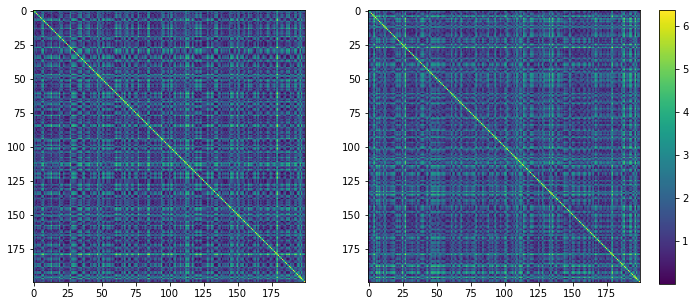

In [18]:
fig = plt.figure(figsize=[11, 5])
ax0 = fig.add_subplot(1,2,1)
ax1 = fig.add_subplot(1,2,2)
cbar_ax = fig.add_axes([.92, 0.12, 0.02, 0.76])

mins = np.min([np.nanmin(dm_initial), np.nanmin(dm_pool)])
maxs = np.max([np.nanmax(dm_initial), np.nanmax(dm_pool)])
im0 = ax0.imshow(dm_initial, vmin=mins, vmax=maxs)
im1 = ax1.imshow(dm_pool, vmin=mins, vmax=maxs)

fig.colorbar(im1, cax=cbar_ax)

Text(0.5, 1.0, 'density distribution')

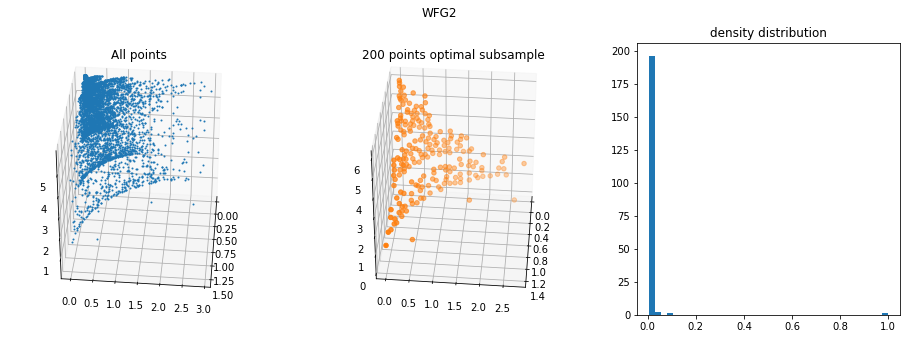

In [19]:
fig = plt.figure(figsize=[16,5])
ax0 = fig.add_subplot(1, 3, 1, projection='3d')
ax1 = fig.add_subplot(1, 3, 2, projection='3d')
ax2 = fig.add_subplot(1, 3, 3)
ax0.plot(*f.T, '.', ms=2, c="C0")
ax1.scatter(*ds_pool.T, c='C1')
ax0.view_init(elev=35, azim=5)
ax1.view_init(elev=35, azim=5)
ax2.hist(w_initial, bins=40)
plt.suptitle(func.__name__)

ax0.set_title('All points')
ax1.set_title('200 points optimal subsample')
ax2.set_title('density distribution')